In [4]:
%cd /content/drive/MyDrive/SUD_PROJECT/neural-punctuator/src

/content/drive/MyDrive/SUD_PROJECT/neural-punctuator/src


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:

import os
from glob import glob
import torch
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import numpy as np

In [7]:
data_path = "/content/drive/MyDrive/SUD_PROJECT/neural-punctuator/models-xlm-roberta-runs/models-xlm-roberta-masked-chinese/"
model_names = ["xlm-roberta-base"]

In [8]:
files = {}
for model_name in model_names:
    f = sorted(glob(data_path + f"{model_name}-epoch*.*"), key=os.path.getmtime)
    files[model_name] = f

In [18]:
def load_scores(model_path):
    checkpoint = torch.load(model_path)
    return checkpoint['metrics']

def get_strict_f_score(report):
    return sum(float(report['cls_report'][output]['f1-score']) for output in ('period', 'question', 'comma')) / 3


metrics = {}
for model_name in model_names:
    m = []
    for file in tqdm(files[model_name]):
        m.append(load_scores(file))
    metrics[model_name] = m
    
with open('reports/metrics.pkl', 'wb') as f:
    pickle.dump(metrics, f)
    
with open('reports/metrics.pkl', 'rb') as f:
    metrics = pickle.load(f)
    
for _, m in metrics.items():
    for epoch in m:
        epoch['strict_f_score'] = get_strict_f_score(epoch)

def best_epoch_by_f_score(metrics):
    best_score = metrics[0]['strict_f_score']
    best_epoch = 0
    for i, m in enumerate(metrics):
        if m['strict_f_score'] > best_score:
            best_score = m['strict_f_score']
            best_epoch = i
    return best_epoch, best_score

def best_epoch_by_loss(metrics):
    best_loss = metrics[0]['loss']
    best_epoch = 0
    for i, m in enumerate(metrics):
        if m['loss'] < best_loss:
            best_loss = m['loss']
            best_epoch = i
    return best_epoch, best_loss

100%|██████████| 4/4 [04:39<00:00, 69.96s/it]


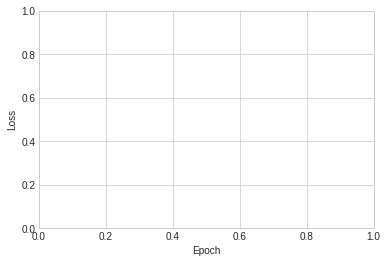

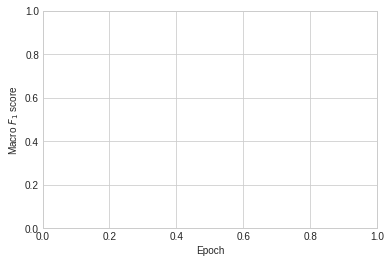

In [10]:
plt.style.use('seaborn-whitegrid')
# plt.title('Valid loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
for model_name, m in metrics.items():
    loss = [float(epoch['loss']) for epoch in m ]
    plt.plot(np.arange(len(loss))+1, loss, '--d')
plt.legend(model_names)
plt.savefig('imgs/valid_loss.pdf')
plt.show()

plt.style.use('seaborn-whitegrid')
# plt.title('Valid F1-score')
plt.ylabel('Macro $F_1$ score')
plt.xlabel('Epoch')
for model_name, m in metrics.items():
    f_score = [float(epoch['strict_f_score']) for epoch in m ]
    plt.plot(np.arange(len(loss))+1, f_score, '--d')
plt.legend(model_names)
plt.savefig('imgs/valid_f1_score.pdf')
plt.show()

In [12]:
!pip install dotmap
!pip install transformers
!pip install -U PyYAML
from neural_punctuator.utils.data import get_config_from_yaml
from neural_punctuator.models.BertPunctuator import BertPunctuator

import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from neural_punctuator.data.dataloader import BertDataset, collate, get_data_loaders, get_datasets_metrics
from neural_punctuator.models.BertPunctuator import BertPunctuator
from torch.optim import AdamW
from torch import nn

from neural_punctuator.utils.io import save, load
from neural_punctuator.utils.metrics import get_total_grad_norm, get_eval_metrics
import numpy as np
import pickle

from torch.utils.data import Dataset, DataLoader
from itertools import product

In [21]:
def combine(pred_num, preds):
    step_num = 512 // pred_num
    multi_preds = [preds[i::pred_num].reshape(-1, preds.shape[-1]) for i in range(pred_num)]
    for i in range(pred_num):
        start_idx = (pred_num - i - 1) * step_num
        end_idx = start_idx + (preds.shape[0] - (pred_num-1)*2) * step_num
        multi_preds[i] = multi_preds[i][start_idx:end_idx]

    multi_preds = np.stack(multi_preds)
    multi_preds = np.log(np.exp(multi_preds).mean(0))
    return multi_preds

def evaluate_multiple_predictions(model_name, model_type, predict_step, device, dataset_type):
    if model_type == 'by_f_score':
        epoch, _ = best_epoch_by_f_score(metrics[model_name])
    elif model_type == 'by_loss':
        epoch, _ = best_epoch_by_loss(metrics[model_name])
    else:
        raise ValueError("Model type not valid, options: by_f_score/by_loss")
        
    print(model_name, model_type, "Epoch: ", epoch+1)

    config = get_config_from_yaml(f'neural_punctuator/configs/config-{model_name}.yaml')
    config.trainer.load_model = f"{model_name}-epoch-{epoch + 1}.pth"

    config.model.predict_step = predict_step
    config.predict.batch_size = 128

    model = BertPunctuator(config)
    model.to(device)

    load(model, None, config)

    test_dataset = BertDataset(dataset_type, config)

    test_loader = DataLoader(test_dataset, batch_size=config.predict.batch_size, collate_fn=collate)

    model.eval()
    all_test_preds = []

    for data in tqdm(test_loader):
        text, targets = data
        with torch.no_grad():
            preds, _ = model(text.to(device))

        all_test_preds.append(preds.detach().cpu().numpy())

    all_test_target = test_dataset.targets[512:-512]
    all_test_preds = np.concatenate(all_test_preds)
    pred_num = config.model.seq_len // config.model.predict_step

    ps = combine(pred_num, all_test_preds)
    _targets = np.array(all_test_target[:ps.shape[0]])

    ps = ps[_targets != -1]
    _targets = _targets[_targets != -1]

    report = get_eval_metrics(_targets, ps, config)
    return report

In [14]:
class BertDataset(Dataset):
    def __init__(self, prefix, config, is_train=False):

        self.config = config
        self.is_train = is_train

        with open(self.config.data.data_path + prefix + "_data.pkl", 'rb') as f:
            texts, targets, _,_,_,_ = pickle.load(f)
            self.encoded_texts = 512 * [0] + [word for t in texts for word in t] + 512 * [0]  # Add padding to both ends
            self.targets = 512 * [-1] + [t for ts in targets for t in ts] + 512 * [-1]

    def __getitem__(self, idx):
        if idx == 164:
            pass
        start_idx = (1+idx) * self.config.model.predict_step
        end_idx = start_idx + self.config.model.seq_len
        return torch.LongTensor(self.encoded_texts[start_idx: end_idx]),\
               torch.LongTensor(self.targets[start_idx: end_idx])

    def __len__(self):
        return int(np.ceil((len(self.encoded_texts)-1024)//self.config.model.predict_step))

In [22]:
device = torch.device('cuda:0')
torch.cuda.set_device(device)

# pred_num_for_tokens = {
# #     ("albert-base-v1", "by_loss"): 32,
# #     ("albert-base-v1", "by_f_score"): 32,
# #     ("bert-base-cased", "by_loss"): 32,
# #     ("bert-base-cased", "by_f_score"): 32,
# #     ("bert-base-uncased", "by_loss"): 32,
# #     ("bert-base-uncased", "by_f_score"): 32,2,
# }

# model_type = 'by_loss'

reports = {}
for model_name, model_type in product(model_names, ('by_loss', 'by_f_score')):
    pred_num_for_token = 1
    while pred_num_for_token <= 64:
        predict_step = 512 // pred_num_for_token
        report = evaluate_multiple_predictions(model_name, model_type, predict_step, device, "valid")
        print(model_name, model_type, pred_num_for_token, get_strict_f_score(report))
        reports[(model_name, model_type, pred_num_for_token)] = report
        pred_num_for_token *=2

xlm-roberta-base by_loss Epoch:  4


Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 1/1 [00:05<00:00,  5.32s/it]

              precision    recall  f1-score   support

       empty      0.999     0.954     0.976     35615
      period      0.366     0.948     0.529       385
    question      0.842     0.870     0.856        92
       comma      0.496     0.926     0.646      1133

    accuracy                          0.953     37225
   macro avg      0.676     0.924     0.752     37225
weighted avg      0.977     0.953     0.961     37225

2021-09-13 06:51:32,470 INFO      Macro precision is: 0.675888065883863
2021-09-13 06:51:32,483 INFO      Macro recall is 0.9243784833391377
2021-09-13 06:51:32,495 INFO      Macro f-score is 0.7515602226951587


xlm-roberta-base by_loss 1 0.6767841096647255
xlm-roberta-base by_loss Epoch:  4


Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 2/2 [00:10<00:00,  5.05s/it]

              precision    recall  f1-score   support

       empty      0.999     0.955     0.976     35365
      period      0.378     0.953     0.541       385
    question      0.798     0.859     0.827        92
       comma      0.503     0.939     0.655      1129

    accuracy                          0.954     36971
   macro avg      0.669     0.926     0.750     36971
weighted avg      0.977     0.954     0.962     36971

2021-09-13 06:53:14,040 INFO      Macro precision is: 0.6693179687764801
2021-09-13 06:53:14,054 INFO      Macro recall is 0.9263676989964045
2021-09-13 06:53:14,067 INFO      Macro f-score is 0.7498053929218829


xlm-roberta-base by_loss 2 0.6742831039563834
xlm-roberta-base by_loss Epoch:  4


Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 3/3 [00:20<00:00,  6.81s/it]

              precision    recall  f1-score   support

       empty      0.999     0.955     0.977     35239
      period      0.379     0.951     0.542       385
    question      0.833     0.870     0.851        92
       comma      0.509     0.942     0.661      1127

    accuracy                          0.955     36843
   macro avg      0.680     0.929     0.758     36843
weighted avg      0.977     0.955     0.962     36843

2021-09-13 06:54:26,948 INFO      Macro precision is: 0.6801142459121163
2021-09-13 06:54:26,960 INFO      Macro recall is 0.9294895090630652
2021-09-13 06:54:26,972 INFO      Macro f-score is 0.7576929541874271


xlm-roberta-base by_loss 4 0.6846464133966202
xlm-roberta-base by_loss Epoch:  4


Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 5/5 [00:40<00:00,  8.06s/it]

              precision    recall  f1-score   support

       empty      0.999     0.955     0.977     35175
      period      0.378     0.951     0.541       385
    question      0.830     0.848     0.839        92
       comma      0.508     0.942     0.660      1127

    accuracy                          0.955     36779
   macro avg      0.679     0.924     0.754     36779
weighted avg      0.977     0.955     0.962     36779

2021-09-13 06:55:29,745 INFO      Macro precision is: 0.6789629363384979
2021-09-13 06:55:29,758 INFO      Macro recall is 0.9240202331891402
2021-09-13 06:55:29,770 INFO      Macro f-score is 0.7543307737516733


xlm-roberta-base by_loss 8 0.6801925189855268
xlm-roberta-base by_loss Epoch:  4


Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 10/10 [01:20<00:00,  8.03s/it]


              precision    recall  f1-score   support

       empty      0.999     0.955     0.977     35111
      period      0.380     0.953     0.544       385
    question      0.830     0.848     0.839        92
       comma      0.510     0.943     0.662      1127

    accuracy                          0.955     36715
   macro avg      0.680     0.925     0.755     36715
weighted avg      0.977     0.955     0.962     36715

2021-09-13 06:57:15,625 INFO      Macro precision is: 0.6798575555318924
2021-09-13 06:57:15,640 INFO      Macro recall is 0.9249351157195109
2021-09-13 06:57:15,652 INFO      Macro f-score is 0.755344285510807
xlm-roberta-base by_loss 16 0.6815041385639096
xlm-roberta-base by_loss Epoch:  4


Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
 42%|████▏     | 8/19 [01:18<01:47,  9.77s/it]


KeyboardInterrupt: ignored

In [ ]:
with open('reports/valid_english.pkl', 'wb') as f:
    pickle.dump(reports, f)

In [24]:
best_pred_num_for_tokens = {}

for model_name, model_type in product(model_names, ('by_loss', 'by_f_score')):
    best_score = 0
    best_pred_num_for_token = 0
    
    pred_num_for_token = 1
    while pred_num_for_token <= 19:
        report = reports[(model_name, model_type, pred_num_for_token)]
        score = get_strict_f_score(report)
        
        if score > best_score:
            best_score = score
            best_pred_num_for_token = pred_num_for_token
        pred_num_for_token *=2
        
    best_pred_num_for_tokens[(model_name, model_type)] = (best_score, best_pred_num_for_token)
best_pred_num_for_tokens

KeyError: ignored

In [ ]:
test_reports = []

for (model_name, model_type), (_, pred_num_for_token) in best_pred_num_for_tokens.items():
    if model_type == 'by_f_score':
        epoch, _ = best_epoch_by_f_score(metrics[model_name])
    elif model_type == 'by_loss':
        epoch, _ = best_epoch_by_loss(metrics[model_name])
    else:
        raise ValueError("Model type not valid, options: by_f_score/by_loss")
        
    predict_step = 512 // pred_num_for_token
    report = evaluate_multiple_predictions(model_name, model_type, predict_step, device, "test")
    print(model_name, model_type, pred_num_for_token, get_strict_f_score(report))
    #test_reports.append((model_name, model_type, pred_num_for_token, epoch, get_strict_f_score(report), report))

In [ ]:
with open('reports/test_english.pkl', 'wb') as f:
    pickle.dump(test_reports, f)

In [ ]:
test_reports

In [ ]:
for model_name, model_type, pred_num_for_token, epoch, strict_f_score, report in test_reports:
    print("Model name\t\tModel type\t# preds/token\tEpoch\tF non-empty\tF")
    
    print(f"{model_name:20}\t{model_type:10}\t"+
          f"{pred_num_for_token}\t\t{epoch}\t{strict_f_score*100:.1f}\t\t{report['f_score']*100:.1f}")
    
    print(" "*18 + "\t".join(('P', 'R', 'F')))
    for punc_type in ('comma', 'period', 'question'):
        print(f"{punc_type:15}", end="")
        for metric_type in ('precision', 'recall', 'f1-score'):        
            print(f"\t{report['cls_report'][punc_type][metric_type]*100:.1f}", end="")
        print()
    print()

# Plots for number of preds per token  selection

In [ ]:
import pickle

with open('reports/valid_english.pkl', 'rb') as f:
    reports = pickle.load(f)

In [ ]:
scores = {}
from itertools import product

for model_name, model_type in product(model_names, ('by_loss', 'by_f_score')):
    pred_num_for_token = 1
    s_ = []
    while pred_num_for_token <= 64:
        report = reports[(model_name, model_type, pred_num_for_token)]
        score = get_strict_f_score(report)
        s_.append(score)
        
        pred_num_for_token *=2
        
    scores[(model_name, model_type)] = s_

In [ ]:
for (model_name, model_type), f_scores in scores.items():
    print(model_name, model_type)
    plt.style.use('seaborn-whitegrid')
    # plt.title('Multiple predictions')
    plt.ylabel('Macro $F_1$ score')
    plt.xlabel('Number of predictions per token')
    plt.xticks(np.arange(int(np.log2(64))+1), [str(2**i) for i in range(0, int(np.log2(64))+1)])
    plt.plot(f_scores[::-1], '--d')
    plt.savefig(f'imgs/valid_multiple_predictions/{model_name}_{model_type}.pdf')
    plt.show()